In [36]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from dynamics import *
import re
import math
from optread import *
from scipy.stats import binom
#set latex font for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Precompute embeddings for all readouts
def precompute_embeddings(datapoints_normalized):
    simulator = RydbergSimulator(
        nsites=nsites,
        atoms=atoms,
        readouts=readouts,
        omega=omega,
        t_start=t_start,
        t_end=t_end,
        t_step=t_step,
        t_rate=t_rate,
        alpha=alpha,
        V_matrix=V_matrix,
        id=0,
        use_wavelet=False
    )
    embeddings = simulator.apply_layer(datapoints_normalized)
    return readouts, embeddings

In [38]:
# Generate regression dataset
X, y = make_regression(n_samples=100, n_features=4, noise=0.1, random_state=402)
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler_X.fit_transform(X)
y = y.reshape(-1, 1)  # Reshape y to a 2D array for normalization
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_normalized = scaler_y.fit_transform(y).flatten() 

# First, split into 60% train and 40% temp (test + val)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y_normalized, test_size=0.4, shuffle=True, random_state=402
)
# Next, split the remaining 40% equally into test (20%) and validation (20%)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=True, random_state=402
)

In [39]:
#use a simple random forest classifier
clf = RandomForestRegressor(n_estimators=50, random_state=402)
clf.fit(X_train, y_train)
#accuracy
y_pred = clf.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
print('Base Test MSE: {}'.format(base_mse))
    

Base Test MSE: 0.015216645802771368


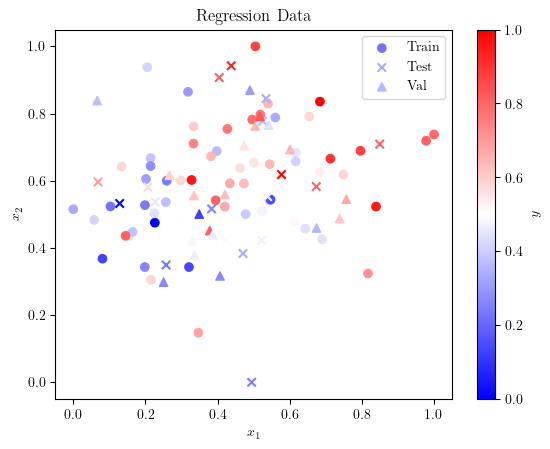

In [40]:
#using bwr cmap plot the regression data x_1 vs x_2 with the color representing the target value
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label='Train', marker='o')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', label='Test', marker='x')
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr', label='Val', marker='^')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Regression Data')
#set colorbar ticks from 0.0 to 1.0
plt.clim(0.0, 1.0)
#set colorbar label to '$y$'
plt.colorbar().set_label(r'$y$')
plt.legend()
plt.show()
#

Plot saved as lattice_plot.pdf


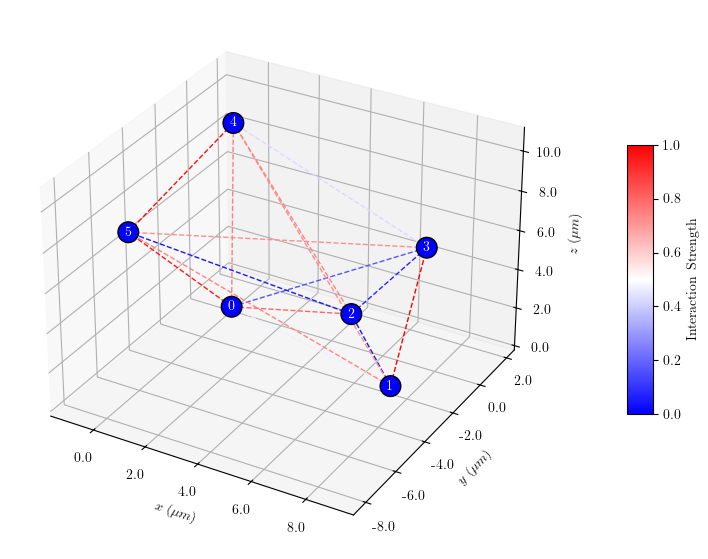

In [104]:
np.random.seed(2)
nsites =6
d = 10 # 10 micron spacing
atoms = np.linspace(0, (nsites - 1) * d, nsites)  # Put atoms in a chain with 10 micron spacing

# Hyperparameters for testing
omega = 2 * np.pi
t_start = 0.0
t_end = 3.0
t_step = 0.5
t_rate = 1.0
alpha = np.random.rand(nsites)  # Random site modulation factors between 0 and 1
V_matrix = np.random.rand(nsites, nsites)
V_matrix = (V_matrix + V_matrix.T) / 2  # Make the interaction matrix symmetric
np.fill_diagonal(V_matrix, 0.1)  # Set diagonal elements to 0.1
#use min-max normalization

# Call the function
plot_3d_lattice(nsites, d, atoms, alpha, V_matrix, save_as_pdf=True, filename="lattice_plot.pdf")

In [105]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_datapoints_normalized = scaler.fit_transform(X_train)
#val_datapoints_normalized = scaler.transform(X_val)
test_datapoints_normalized = scaler.transform(X_test)
#custom_readouts = ["IIIZII","ZIIIII","IZIIII","XXXIII","IIIXXX","IIIIIX"]

#readouts = generate_readouts(nsites, custom_readouts)
readouts = generate_readouts(nsites)  #default readouts

_, train_embeddings = precompute_embeddings(train_datapoints_normalized)
#_, val_embeddings = precompute_embeddings(val_datapoints_normalized)
_, test_embeddings = precompute_embeddings(test_datapoints_normalized)


train_embeddings=train_embeddings/(2**nsites) #normalize embeddings
#val_embeddings=val_embeddings/(2**nsites) #normalize embeddings
test_embeddings=test_embeddings/(2**nsites) #normalize embeddings

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


In [106]:
#check the mse of the embeddings
clf = RandomForestRegressor(n_estimators=50, random_state=402)
clf.fit(train_embeddings, y_train)
#accuracy   
y_pred = clf.predict(test_embeddings)
qrc_full_mse = mean_squared_error(y_test, y_pred)
print('QRC Full MSE: {}'.format(qrc_full_mse))

QRC Full MSE: 0.002266994512607808


In [107]:
t_steps = np.arange(t_start+t_step, t_end+t_step, t_step)
#reshape the embeddings to be in the shape of (n_samples, len(t_steps), :))
embd_per_t = train_embeddings.reshape(train_embeddings.shape[0], len(t_steps), -1)
embd_per_t_val = val_embeddings.reshape(val_embeddings.shape[0], len(t_steps), -1)
embd_per_t_test = test_embeddings.reshape(test_embeddings.shape[0], len(t_steps), -1)

In [108]:
embd_per_t[0][0]

array([ 0.56112361,  0.55861109,  0.65889043,  0.54819543,  0.61836819,
        0.61675566,  0.63653395,  0.58969091,  0.66261751,  0.67000363,
        0.61168386,  0.64275135,  0.67447872,  0.63458994,  0.6623575 ,
        0.67830157,  0.67631353,  0.67075474,  0.58203993,  0.59046732,
        0.65689527,  0.60557459,  0.62044198,  0.65484438,  0.64535065,
        0.57871299,  0.66048895,  0.66344887,  0.63757309,  0.64039152,
        0.63431711,  0.58594   ,  0.66554659,  0.66732835,  0.60146773,
        0.64238804, -0.0227424 ,  0.03559844, -0.10172739,  0.19185986,
       -0.15126027, -0.06943819,  0.11015229, -0.12118578,  0.01397501,
        0.1092034 , -0.12549882,  0.03656551,  0.09181418, -0.08164935,
       -0.01478653,  0.10512012, -0.11476433,  0.04944419,  0.00621982,
        0.01494109, -0.0864462 ,  0.17492578, -0.13118341, -0.02034515,
        0.11888646, -0.13915871,  0.03091531,  0.0962835 , -0.09918169,
       -0.02153145,  0.13459797, -0.14968744,  0.02430003,  0.12

In [109]:
embd_per_t[0][0]

array([ 0.56112361,  0.55861109,  0.65889043,  0.54819543,  0.61836819,
        0.61675566,  0.63653395,  0.58969091,  0.66261751,  0.67000363,
        0.61168386,  0.64275135,  0.67447872,  0.63458994,  0.6623575 ,
        0.67830157,  0.67631353,  0.67075474,  0.58203993,  0.59046732,
        0.65689527,  0.60557459,  0.62044198,  0.65484438,  0.64535065,
        0.57871299,  0.66048895,  0.66344887,  0.63757309,  0.64039152,
        0.63431711,  0.58594   ,  0.66554659,  0.66732835,  0.60146773,
        0.64238804, -0.0227424 ,  0.03559844, -0.10172739,  0.19185986,
       -0.15126027, -0.06943819,  0.11015229, -0.12118578,  0.01397501,
        0.1092034 , -0.12549882,  0.03656551,  0.09181418, -0.08164935,
       -0.01478653,  0.10512012, -0.11476433,  0.04944419,  0.00621982,
        0.01494109, -0.0864462 ,  0.17492578, -0.13118341, -0.02034515,
        0.11888646, -0.13915871,  0.03091531,  0.0962835 , -0.09918169,
       -0.02153145,  0.13459797, -0.14968744,  0.02430003,  0.12

The original value of the sample is:  [0.10306162 0.52340539 0.55548486 0.26098169]


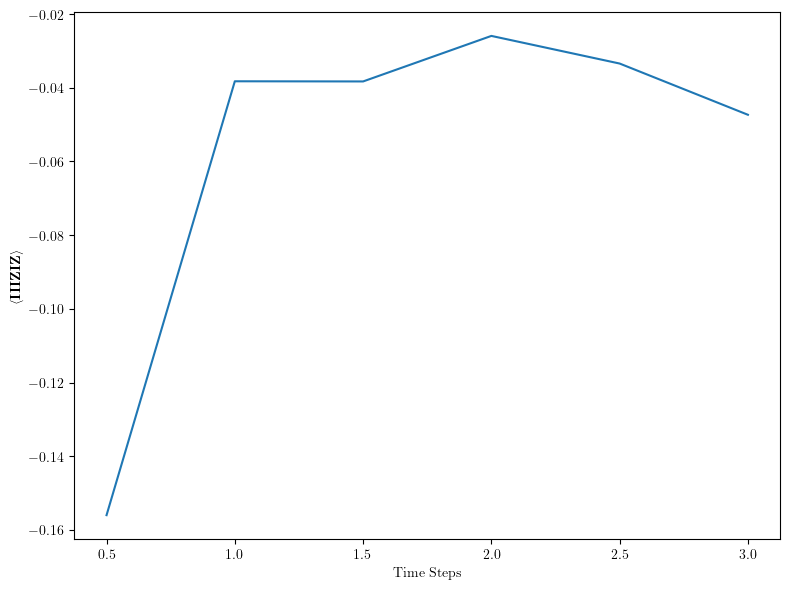

In [110]:
# Sample Index and Readout Index
sample_idx = 0
readout_idx = 101  # Specify the readout index to visualize

print("The original value of the sample is: ", X_train[sample_idx])

# Plot specific readout
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_steps, embd_per_t[sample_idx, :, readout_idx])

# Convert readout string to LaTeX with braket notation
readout = readouts[readout_idx].to_string()
title = re.search(r"[IXYZ]+", readout).group()
latex_title = f"$\\langle \\mathbf{{{title}}} \\rangle$"

ax.set_xlabel('Time Steps')
ax.set_ylabel(latex_title)
plt.tight_layout()
plt.show()

In [138]:
int(embd_per_t[0].shape[1] * 0.25)

27

In [130]:
#optimize the feature selection on observable selections (readouts) (reasonable performance but faster)
retention = int(embd_per_t[0].shape[1] * 0.25)
results = genetic_algorithm_feature_selection(
    embd_per_t, embd_per_t, y_train, y_train,
    base_mse=base_mse,
    qrc_full_mse=qrc_full_mse,
    model=clf,
    pop_size=25,
    n_gen=100,
    crossover_rate=0.7,
    mutation_rate=0.2,
    elitism_count=2,
    n_jobs=-1,
    max_features_selected=retention
)

Iteration 1/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00025572, best_r2=0.99512549
Iteration 2/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00025572, best_r2=0.99512549
Iteration 3/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 4/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 5/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 6/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 7/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 8/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 9/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00022498, best_r2=0.99571147
Iteration 10/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=

In [131]:
retention

54

In [132]:
# final results is a list of dicts for each iteration
# The last entry has the best overall
final_info = results[-1]
print("\n=== FINAL GA RESULTS ===")
print(f"Iteration: {final_info['iteration']}")
print(f"Best val MSE: {final_info['best_mse']:.8f}")
best_mask = final_info['best_mask']
#print("Features selected:", np.where(best_mask == 1)[0])
#print selcted feature out of tiotal features
selected_features = np.where(best_mask == 1)[0]
print(f'The selected embeddings are of shape: {train_embeddings[:,selected_features].shape}')


=== FINAL GA RESULTS ===
Iteration: 100
Best val MSE: 0.00019843
The selected embeddings are of shape: (60, 42)


In [133]:
regressor_QRC = clf
regressor_QRC.fit(train_embeddings[:,selected_features], y_train)
train_preds_QRC = regressor_QRC.predict(train_embeddings[:,selected_features])
test_preds_QRC = regressor_QRC.predict(test_embeddings[:,selected_features])
#the improvement in mse
improvement = (base_mse - mean_squared_error(y_test, test_preds_QRC)) / base_mse * 100
print('QRC Test MSE: {}'.format(mean_squared_error(y_test, test_preds_QRC)))
print('QRC Improvement: {:.2f}%'.format(improvement))

QRC Test MSE: 0.002217268858586637
QRC Improvement: 85.43%


In [134]:
#optimize the feature selection on the full embeddings (performance is good but slow)
retention = int(len(train_embeddings[0])*0.25) #only keep 25% of the features
results = genetic_algorithm_feature_selection(
    train_embeddings, train_embeddings, y_train, y_train,
    base_mse=base_mse,
    qrc_full_mse=qrc_full_mse,
    model=clf,
    pop_size=25,
    n_gen=100,
    crossover_rate=0.7,
    mutation_rate=0.2,
    elitism_count=2,
    n_jobs=-1,
    max_features_selected=retention
)

Iteration 1/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00027756, best_r2=0.99470913
Iteration 2/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00023083, best_r2=0.99559995
Iteration 3/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00023083, best_r2=0.99559995
Iteration 4/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 5/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 6/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 7/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 8/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 9/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=0.00020890, best_r2=0.99601799
Iteration 10/100: base_mse=0.01521665, qrc_full_mse=0.00226699, best_mse=

In [135]:
results_dict = {}
final_info = results[-1]
best_mse = final_info['best_mse']
final_info = results[-1]
best_mask = final_info['best_mask']
improvement = (base_mse - best_mse) / base_mse * 100

results_dict[nsites] = {
    "nsites": nsites,
    "qrc_mse": qrc_full_mse,
    "best_mse": best_mse,
    "best_mask": best_mask,
    "selected_features": np.where(best_mask == 1)[0],
    "length_selected_features": len(np.where(best_mask == 1)[0]),
    "original_length": len(train_embeddings[0]),
    "improvement": improvement
}

# final results is a list of dicts for each iteration
# The last entry has the best overall
final_info = results[-1]
print("\n=== FINAL GA RESULTS ===")
print(f"Iteration: {final_info['iteration']}")
print(f"Best MSE: {final_info['best_mse']:.8f}")
best_mask = final_info['best_mask']
#print("Features selected:", np.where(best_mask == 1)[0])
#print selcted feature out of tiotal features
selected_features = np.where(best_mask == 1)[0]
print(f'The selected embeddings are of shape: {train_embeddings[:,selected_features].shape}')


=== FINAL GA RESULTS ===
Iteration: 100
Best MSE: 0.00019608
The selected embeddings are of shape: (60, 162)


In [136]:
regressor_QRC = clf
regressor_QRC.fit(train_embeddings[:,selected_features], y_train)
train_preds_QRC = regressor_QRC.predict(train_embeddings[:,selected_features])
test_preds_QRC = regressor_QRC.predict(test_embeddings[:,selected_features])
#the improvement in mse
improvement = (base_mse - mean_squared_error(y_test, test_preds_QRC)) / base_mse * 100
print('QRC Test MSE: {}'.format(mean_squared_error(y_test, test_preds_QRC)))
print('QRC Improvement: {:.2f}%'.format(improvement))

QRC Test MSE: 0.0023536349357525304
QRC Improvement: 84.53%


In [52]:
selected_features

array([  6,  10,  16,  18,  19,  21,  24,  27,  38,  41,  44,  45,  52,
        53,  59,  62,  63,  68,  70,  72,  73,  82,  93,  98, 100, 103,
       105, 106, 109, 111, 115, 118, 119, 130, 141, 146, 152, 153, 154,
       161, 174, 179, 180, 184, 188, 201, 203, 220, 223, 231, 240, 252,
       253, 255, 256, 260, 263, 264, 269, 272, 274, 275, 278, 279, 293,
       294, 295, 297, 299, 304, 310, 315, 316, 317, 321, 322, 331, 334,
       336, 339, 350, 351, 357, 360, 364, 366, 368, 369, 372, 377, 385,
       390, 397, 402, 403, 406, 409, 411, 417, 419, 421, 422, 424, 428,
       429, 441, 443, 449, 455, 459, 466, 467, 471, 478, 482, 483, 485,
       486, 489, 490, 491, 496, 505, 509, 515, 517, 518, 521, 525, 529,
       530, 531, 543, 546, 549, 561, 563, 568, 573, 576, 579, 580, 581,
       585, 586, 594, 600, 602, 606, 611, 615, 616, 618, 620, 624, 627,
       629, 632, 634, 636, 642, 647])

In [54]:
embd_per_t.shape

(60, 6, 108)